In [1]:
import pyfiles.HFSAnalyzer as HFSA
import pyfiles.groupplot as gp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import time
import matplotlib.gridspec as gridspec


sns.set_context('talk')
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_palette('colorblind')
%matplotlib inline

df = HFSA.directory_to_df('./log')
df.to_pickle("HFSDataFrame.pickle")

#df = HFSA.add_Dir_to_pickle_df("HFSDataFrame.pickle", dirname='../HFS/log', moveto='../archive/logfiles')
df3D = df[df['ndim'] == 3]
df3D = df3D[np.isfinite(df3D['Dav_final_val'])]
df2D = df[df['ndim'] == 2]

CPU times: user 3min 39s, sys: 768 ms, total: 3min 40s
Wall time: 3min 40s


In [2]:
'''
reload(HFSA)
fig = plt.figure(figsize=(7,7))
axplot = HFSA.axplot_1stBZ
kwargs = {'spec_alpha' : 0.5 , 'scale' : 1.05, 'labels' : True}
fig, axes = HFSA.df_ApplyAxplotToRows(df[df['Nk'] == 57], None, axplot, **kwargs)
plt.tight_layout()
#fig.tight_layout(pad=1.3)
plt.savefig('../images/1stBZ.eps', format='eps', transparent=True)
plt.show()

fig = plt.figure(figsize=(7,7))
axplot = HFSA.axplot_exc_hist
fig, axes =  HFSA.df_ApplyAxplotToRows(df[df['Nk'] == 57], None, axplot)
plt.tight_layout()
fig.tight_layout(pad=1.3)
plt.locator_params(nbins=5)
plt.savefig('../images/exchist.eps', format='eps', transparent=True)
plt.show()



fig = plt.figure(figsize=(7,7))
HFSA.df_ApplyAxplotToRows(df2D[df2D['Nk'] == 57], None, HFSA.axplot_energy_compare)
plt.tight_layout()
#fig.tight_layout(pad=1.3)
#plt.savefig('../images/energycompare.eps', format='eps', transparent=True)
plt.show()
'''

"\nreload(HFSA)\nfig = plt.figure(figsize=(7,7))\naxplot = HFSA.axplot_1stBZ\nkwargs = {'spec_alpha' : 0.5 , 'scale' : 1.05, 'labels' : True}\nfig, axes = HFSA.df_ApplyAxplotToRows(df[df['Nk'] == 57], None, axplot, **kwargs)\nplt.tight_layout()\n#fig.tight_layout(pad=1.3)\nplt.savefig('../images/1stBZ.eps', format='eps', transparent=True)\nplt.show()\n\nfig = plt.figure(figsize=(7,7))\naxplot = HFSA.axplot_exc_hist\nfig, axes =  HFSA.df_ApplyAxplotToRows(df[df['Nk'] == 57], None, axplot)\nplt.tight_layout()\nfig.tight_layout(pad=1.3)\nplt.locator_params(nbins=5)\nplt.savefig('../images/exchist.eps', format='eps', transparent=True)\nplt.show()\n\n\n\nfig = plt.figure(figsize=(7,7))\nHFSA.df_ApplyAxplotToRows(df2D[df2D['Nk'] == 57], None, HFSA.axplot_energy_compare)\nplt.tight_layout()\n#fig.tight_layout(pad=1.3)\n#plt.savefig('../images/energycompare.eps', format='eps', transparent=True)\nplt.show()\n"

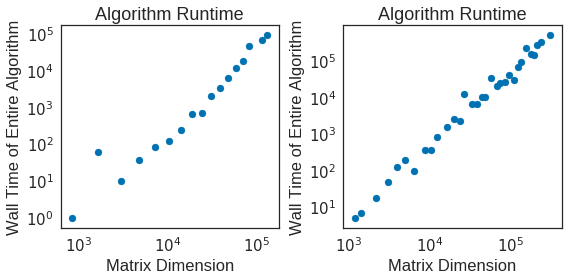

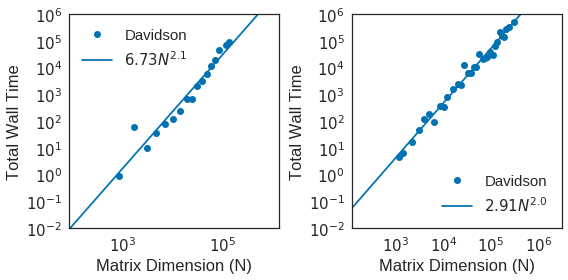

/home/evan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


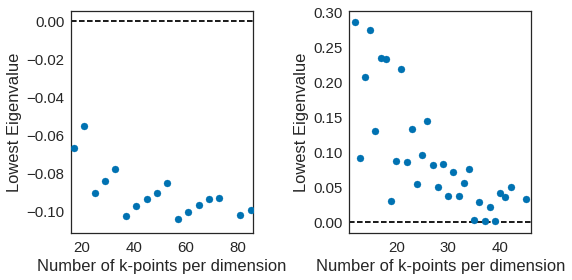

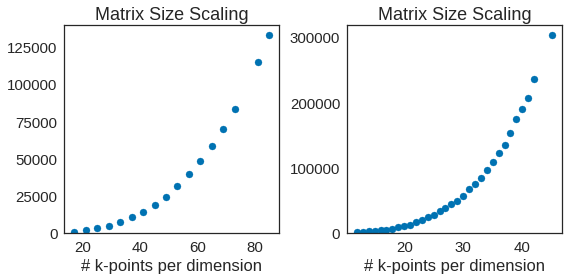

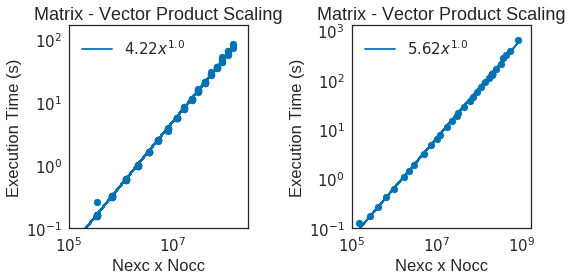

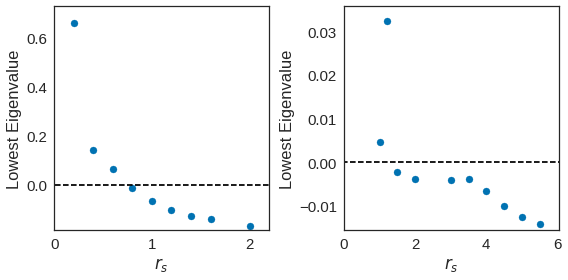

In [76]:
import imp
imp.reload(HFSA)

df2D12 = df2D[np.isclose(df2D['rs'].as_matrix(), 1.2)]
df3D12 = df3D[np.isclose(df3D['rs'].as_matrix(), 1.2)]
dflist_maxNk = [HFSA.only_max(df2D, 'rs', 'Nk'), HFSA.only_max(df3D, 'rs', 'Nk')]
dflist_r12 = [df2D12, df3D12]
dflist = [df2D, df3D]

RHF2D = df2D[df2D['mycase'].as_matrix() == ' cRHF2cUHF']
RHF2D12 = RHF2D[np.isclose(RHF2D['rs'].as_matrix(), 1.2)]

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist_r12, fig, HFSA.plot_runtime, shape=(1, 2))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist_r12, fig, HFSA.plot_diag_scaling, shape=(1, 2))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist_r12, fig, HFSA.plot_dav_vs_full, shape=(1, 2))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist_r12, fig, HFSA.plot_matrix_scaling, shape=(1, 2))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist, fig, HFSA.plot_mvproduct_scaling, shape=(1, 2))
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 4))
HFSA.subplotByDfList(dflist_maxNk, fig, HFSA.plot_stability, shape=(1, 2))
plt.tight_layout()
plt.show()

In [ ]:
ax.le